In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima


from sktime.utils.plotting import plot_series



# Стандартные импорты plotly
import plotly as py
from pylab import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline()
# Устанавливаем глобальную тему 
cf.set_config_file(world_readable=True, theme='pearl', offline=True)

In [374]:
np.random.seed(123)

# Параметры
n_products = 500
start_date = '2023-11-01'
end_date = '2024-11-30'  
dates = pd.date_range(start=start_date, end=end_date, freq='D')
n_days = len(dates)

# Категории и подкатегории
categories = {
    'Куртка': ['Куртка кожаная', 'Куртка весенняя', 'Куртка зимняя'],
    'Шуба': ['Шуба искуственная', 'Шуба натуральная'],
    'Пальто': ['Пальто'],
    'Тренчкот':['Тренчкот'],
    'Пиджак':['Пиджак'],
    'Дубленка':['Дубленка авиатор','Дубленка двустороняя']
}

seasonality = {
    'Куртка кожаная':       [0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.5, 1.8, 2.2, 2.5, 2.3, 1.8],  # пик осень-зима
    'Куртка весенняя':      [1.8, 2.2, 2.5, 2.0, 1.5, 1.0, 0.8, 0.6, 0.5, 0.4, 0.5, 0.7],  # пик весна, спад летом
    'Куртка зимняя':        [0.5, 0.7, 1.0, 1.2, 1.5, 1.8, 2.0, 2.3, 2.5, 2.8, 2.5, 2.0],  # сильный зимний пик
    'Пальто':               [0.7, 0.9, 1.1, 1.3, 1.5, 1.4, 1.2, 1.0, 1.1, 1.4, 1.3, 1.0],  # умеренная сезонность
    'Тренчкот':             [0.8, 1.0, 1.3, 1.6, 1.8, 1.5, 1.2, 1.0, 1.1, 1.3, 1.2, 0.9],  # пик весна-осень
    'Пиджак':               [0.8, 1.0, 1.2, 1.5, 1.7, 1.6, 1.3, 1.1, 1.0, 1.1, 1.0, 0.8],  # плавная сезонность
    'Дубленка авиатор':     [0.4, 0.5, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.4, 2.7, 2.5, 1.9],  # зимний пик
    'Дубленка двустороняя': [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0],  # зимний пик чуть сильнее
    'Шуба искуственная':   [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0],  # зимний пик
    'Шуба натуральная':     [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0]   # зимний пик
}


# Маркетплейсы (пример)
marketplaces = ['OZ', 'WB']

# Генерируем товары с категориями, подкатегориями и маркетплейсом
products = []
for i in range(n_products):
    category = np.random.choice(list(categories.keys()))
    subcategory = np.random.choice(categories[category])
    sku = f'product_{i+1:04d}'  # 4 цифры для уникальности
    
    marketplace = np.random.choice(marketplaces)
    
    # Скидка СПП: 70% товаров в диапазоне 15-22%, 30% с 0
    discount_spp = np.random.uniform(0.15, 0.22) if np.random.rand() < 0.7 else 0.0
    
    # Платная приёмка: у 30% товаров есть сумма от 200 до 2000
    paid_reception_sum = np.random.uniform(200, 2000) if np.random.rand() < 0.3 else 0.0
    
    products.append({
        'sku': sku,
        'category': category,
        'subcategory': subcategory,
        'marketplace': marketplace,
        'discount_spp': discount_spp,
        'paid_reception_sum': paid_reception_sum
    })
products_df = pd.DataFrame(products)

# Функция генерации редких изменений цен (3 раза за период)
def generate_prices(n_days, n_changes=3, base_price=1000):
    change_points = sorted(np.random.choice(range(n_days), size=n_changes, replace=False))
    prices = []
    current_price = base_price
    idx_cp = 0
    for day in range(n_days):
        if idx_cp + 1 < n_changes and day >= change_points[idx_cp + 1]:
            idx_cp += 1
            change_factor = 1 + np.random.uniform(-0.15, 0.15)
            current_price = max(50, current_price * change_factor)
        prices.append(current_price)
    return prices

# Генерация рекламных кампаний
def generate_ad_costs(n_days):
    ad_costs = np.zeros(n_days)
    n_campaigns = np.random.randint(1, 3)
    for _ in range(n_campaigns):
        start = np.random.randint(0, n_days - 14)
        duration = np.random.randint(7, 15)
        daily_cost = np.random.uniform(500, 1500)
        ad_costs[start:start+duration] = daily_cost
    return ad_costs

all_data = []

for idx, row in products_df.iterrows():
    sku = row['sku']
    category = row['category']
    subcategory = row['subcategory']
    marketplace = row['marketplace']
    discount_spp = row['discount_spp']
    paid_reception_sum = row['paid_reception_sum']
    
    base_price = np.random.uniform(1000, 5000)
    prices = generate_prices(n_days, n_changes=3, base_price=base_price)
    
    # Получаем сезонные коэффициенты для каждого дня
    month_indices = dates.month - 1  # месяцы от 0 до 11
    seasonal_factors = np.array([seasonality[subcategory][m] for m in month_indices])
    
    # Генерация заказов с учётом сезонности (базовый лямбда = 2, умножаем на сезонный коэффициент)
    base_lambda = 2
    adjusted_lambda = base_lambda * seasonal_factors
    orders = np.random.poisson(adjusted_lambda)
    
    # Продажи и возвраты как раньше
    sales = np.array([min(o, np.random.binomial(o, 0.9)) for o in orders])
    returns = (sales * np.random.uniform(0.01, 0.05, n_days)).astype(int)
    
    # Начальный запас — зависит от сезона, чтобы запасы были выше в предсезонье
    # Средний запас умножаем на средний сезонный коэффициент за первые 7 дней периода
    initial_stock_base = np.random.randint(50, 200)
    initial_season_factor = seasonal_factors[:7].mean()
    initial_stock = int(initial_stock_base * initial_season_factor)
    
    stock = np.zeros(n_days, dtype=int)
    stock[0] = initial_stock + orders[0] - sales[0] + returns[0]
    
    for day in range(1, n_days):
        # Можно добавить небольшое сезонное влияние на поступления (orders уже сезонные)
        stock[day] = max(0, stock[day-1] + orders[day] - sales[day] + returns[day])
    
    storage_cost_per_unit = np.random.uniform(1, 5)
    storage_sum = stock * storage_cost_per_unit
    
    logistics_sum = sales * np.random.uniform(10, 50)
    
    penalties = np.zeros(n_days)
    penalty_days = np.random.choice(n_days, size=max(1, n_days // 100), replace=False)
    penalties[penalty_days] = np.random.uniform(100, 1000, size=len(penalty_days))
    
    ad_costs = generate_ad_costs(n_days)
    
    product_data = pd.DataFrame({
        'date': dates,
        'sku': sku,
        'subject': category,
        'subcategory': subcategory,
        'marketplace': marketplace,
        'spp': discount_spp,
        'paid_reception_sum': paid_reception_sum,
        'orders': orders,
        'sales_count': sales,
        'return_count': returns,
        'price': prices,
        'storage_sum': storage_sum,
        'logistics_sum': logistics_sum,
        'penalties_sum': penalties,
        'ad_cost_sum': ad_costs,
        'stock': stock
    })
    
    all_data.append(product_data)

df = pd.concat(all_data).reset_index(drop=True)

In [375]:
# Предрасчёты для временных рядов

df['sales_with_return'] = df['sales_count'] - df['return_count']
df['price_spp'] = df.apply(lambda row: row['price']*row['spp'], axis=1)
df['sales'] = df['price']*df['sales_count']
df['return'] = df['price']*df['return_count']
df['sales_spp'] = df['price_spp']*df['sales_count']
df['return_spp'] = df['price_spp']*df['return_count']
df['real_commission'] = df['spp'].apply(lambda x: (0.25 - x))
df['revenue'] = df['sales_with_return']*df['price']
df['revenue_spp'] = df['sales_with_return']*df['price_spp']

df['week'] = df['date'].apply(lambda d: d.week)

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [376]:
df_gr = df[df['subcategory']=='Шуба натуральная'].groupby(['date'])[['sales_with_return']].sum() # \/


def visa(data, metric):
    data.iplot(y=metric,kind='line',xTitle='date', yTitle=metric)

visa(df_gr, 'sales_with_return')

C:\Users\Пользователь\AppData\Roaming\Python\Python312\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



In [377]:
# Проверка стационарности продаж
result = adfuller(df_gr)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

df_gr = df_gr.dropna()

ADF Statistic: -1.3026
p-value: 0.6280


In [378]:
df_gr_diff = df_gr.diff().dropna()
# df_gr_diff = np.log(df_gr)

df_gr.iplot(y='sales_with_return',kind='line',xTitle='date', yTitle='sales_with_return')

C:\Users\Пользователь\AppData\Roaming\Python\Python312\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



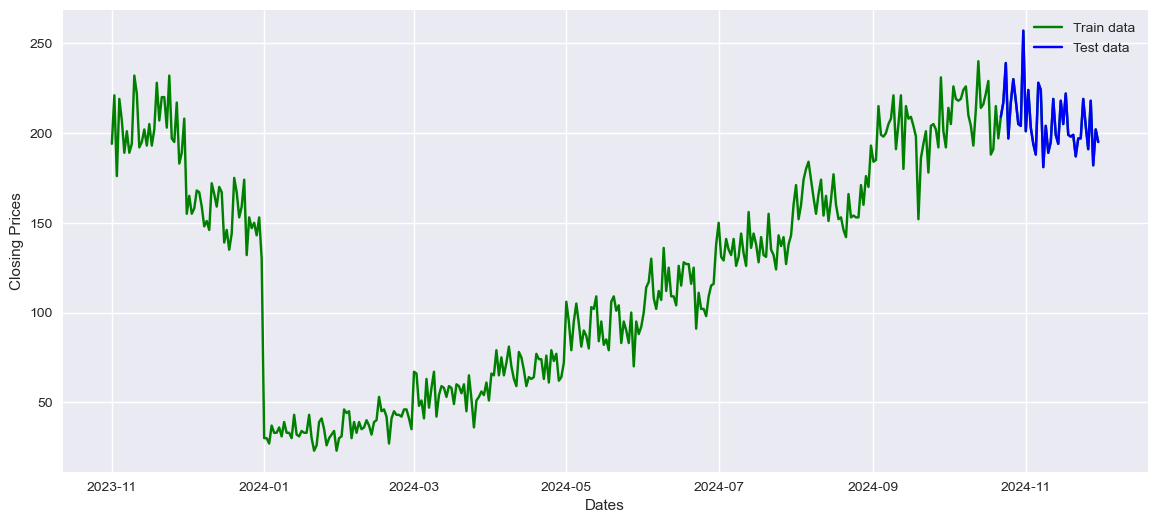

In [379]:
train_data, test_data = df_gr[3:int(len(df_gr)*0.9)], df_gr[int(len(df_gr)*0.9):]

plt.figure(figsize=(14,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_gr, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

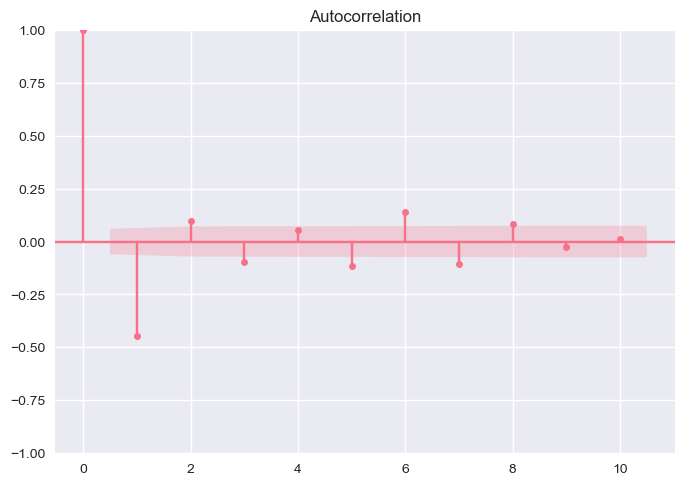

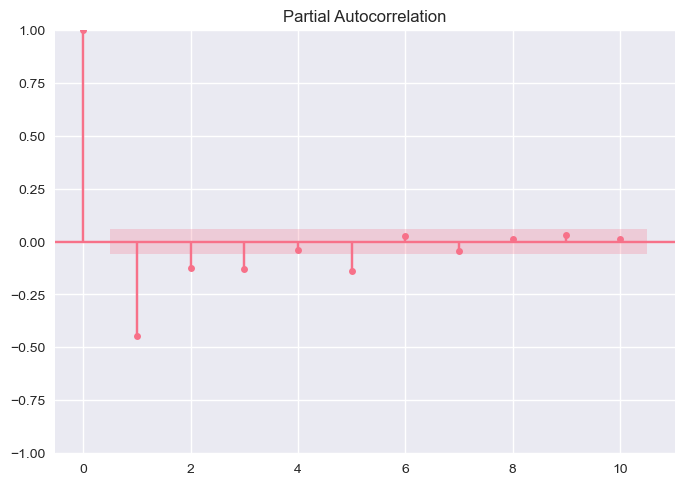

In [281]:
# Строим графики автокорреляции (ACF) и частичной автокорреляции (PACF) для определения p и q
plot_acf(df_gr_diff, lags=10)
plot_pacf(df_gr_diff, lags=10)
plt.show()


# q = 13
# p = 3

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8045.458, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7861.180, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7839.347, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7841.226, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7841.275, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7830.268, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7829.119, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7834.628, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7829.485, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=7829.971, Time=0.39 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=7829.852, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7834.562, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=7831.489, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7830.727, Time=0.75 sec

Best model:  ARIMA(2,0,2)(0,0,0)

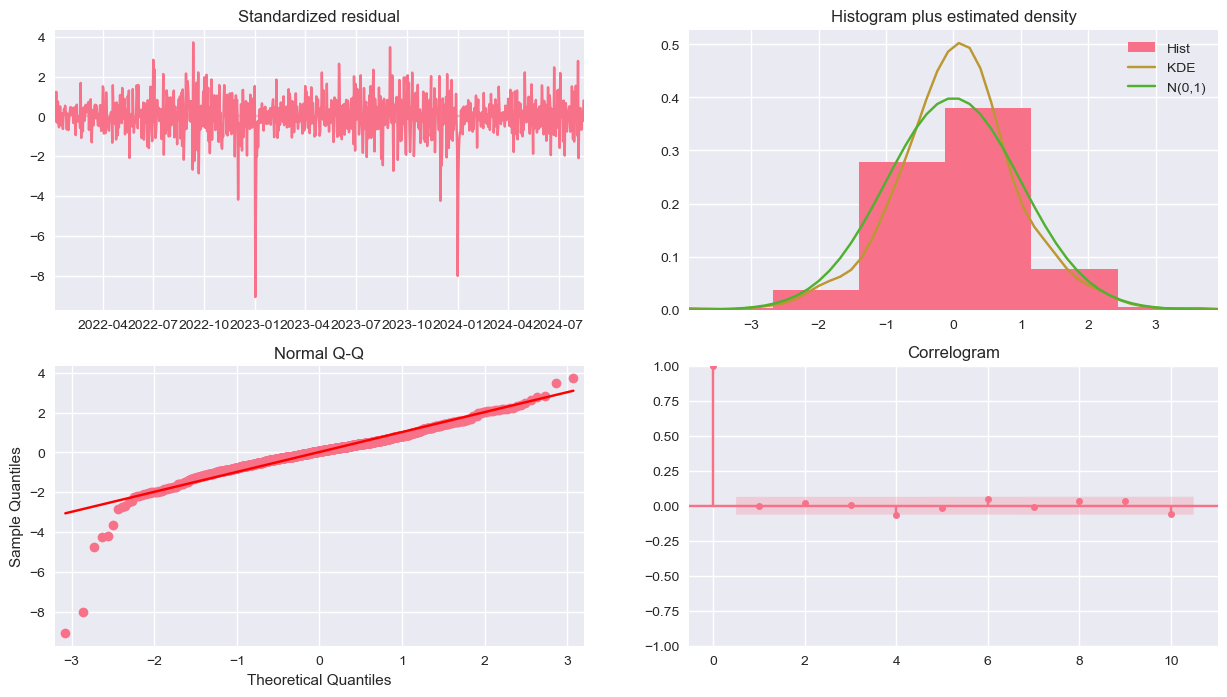

Лучшие параметры: ARIMA(2, 0, 2)


In [282]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

print(f'Лучшие параметры: ARIMA{model_autoARIMA.order}')

In [338]:
p, d, q = 0, 0, 12


# Обучаем модель ARIMA
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      sales_with_return   No. Observations:                  955
Model:                ARIMA(0, 0, 12)   Log Likelihood               -4033.234
Date:                 Пн, 02 июн 2025   AIC                           8094.468
Time:                        20:40:23   BIC                           8162.532
Sample:                    01-04-2022   HQIC                          8120.395
                         - 08-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.7202      4.766     23.858      0.000     104.378     123.062
ma.L1          0.7240      0.030     23.887      0.000       0.665       0.783
ma.L2          0.8330      0.039     21.339      0.0

In [339]:
# Делаем прогноз
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

mae = mean_absolute_error(test_data, forecast)
rmae = np.sqrt(mae)
print(f'MAE: {mae:.2f}')
print(f'RMAE: {rmae:.2f}')

MAE: 81.24
RMAE: 9.01


In [336]:
forecast_rd0 = forecast.cumsum()
forecast_rd = forecast_rd0 + test_data

ma = df_gr.rolling(12).mean()

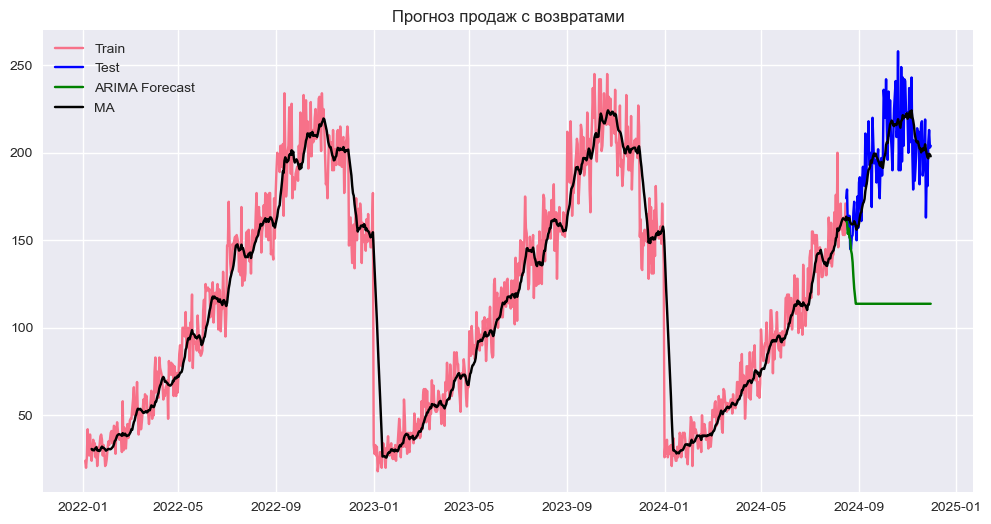

In [340]:
# Визуализируем результаты прогноза и реальных значений
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test',color='blue')
plt.plot(test_data.index, forecast, label='ARIMA Forecast',color='green')
plt.plot(ma.index, ma, label='MA',color='black')
plt.title('Прогноз продаж с возвратами')
plt.legend()
plt.show()


## Прогноз по видео уроку "Временные ряды в python"

348 48


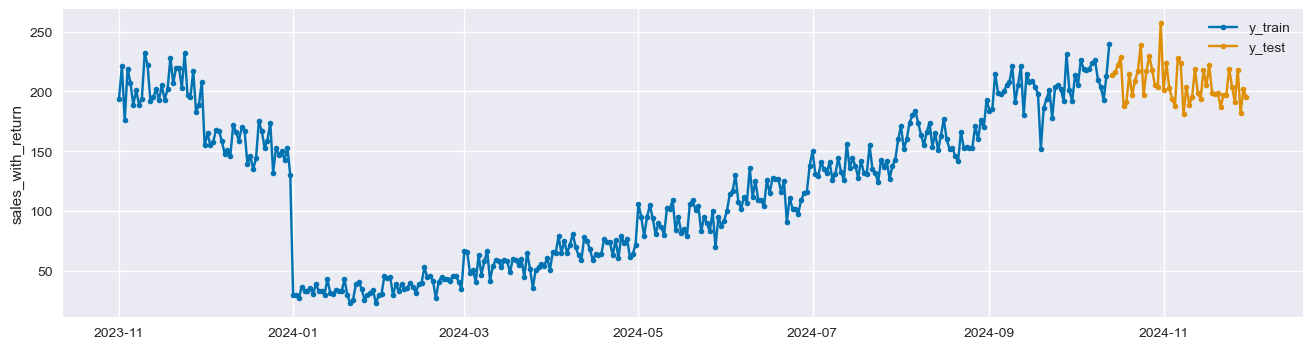

In [380]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(df_gr, test_size=48)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [390]:
# Создаём набор индексов на прогноз
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

y_train.index = pd.date_range(start=y_train.index[0], periods=len(y_train), freq='D')


14.00173611111111


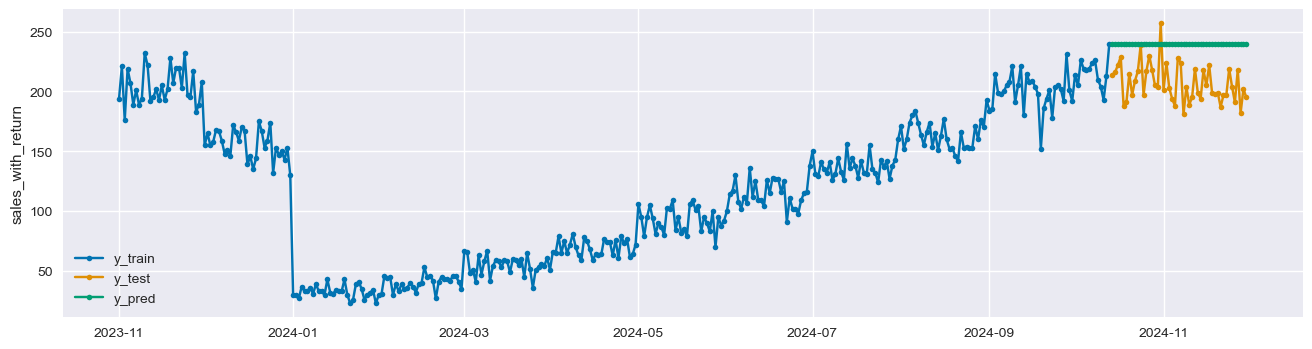

In [387]:
## Наивный проноз

from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

6.3618727366787375


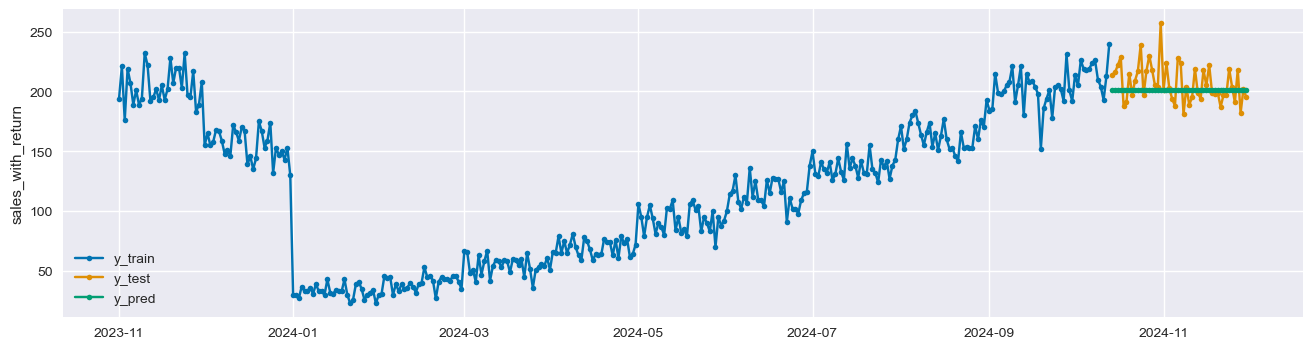

In [388]:
## наивный по среднему

forecaster = NaiveForecaster(strategy="mean", window_length=48)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

8.253709126542182


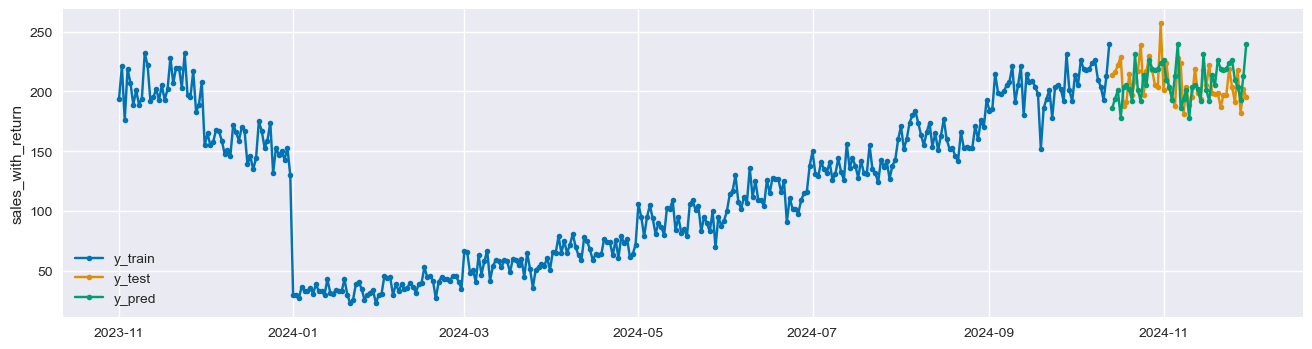

In [393]:
## С сезонностью

forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

9.495968597976516


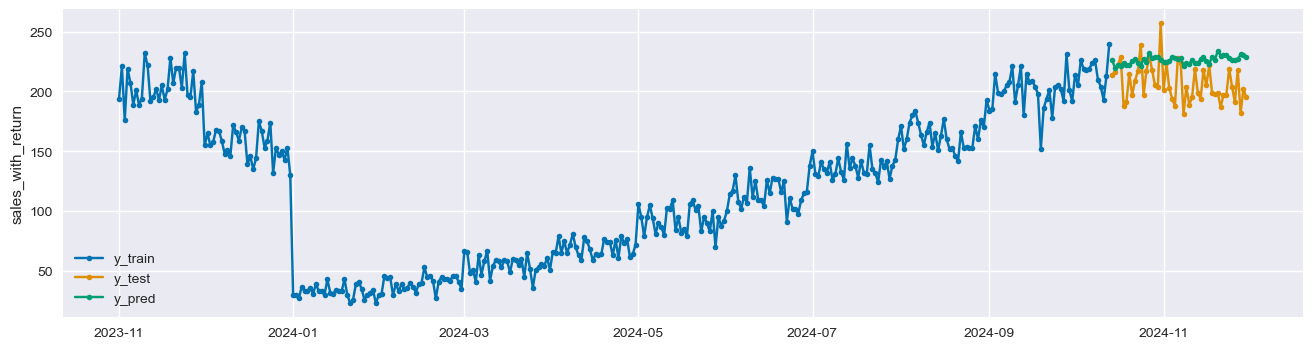

In [395]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=24)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

print(mape(y_pred, y_test))

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

9.166068082532902


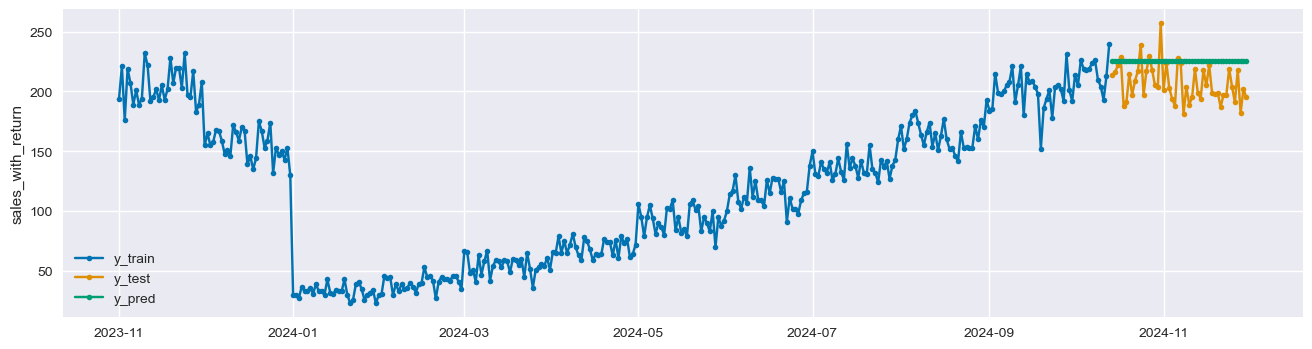

In [396]:
from sktime.forecasting.ets import AutoETS

# Делаем перебор и выбираем лучшую модель по информационному критерию
forecaster = AutoETS(auto=True, n_jobs=-1, information_criterion='bic')
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

print(mape(y_pred, y_test))

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

                        Exponential Smoothing Results                         
Dep. Variable:      sales_with_return   No. Observations:                  348
Model:                   ETS(A, A, A)   Log Likelihood               -1410.279
Date:                 Ср, 04 июн 2025   AIC                           2878.558
Time:                        12:18:55   BIC                           2990.271
Sample:                    11-01-2023   HQIC                          2923.033
                         - 10-13-2024   Scale                          193.867
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.5576      0.037     14.902      0.000       0.484       0.631
smoothing_trend          0.0001      0.005      0.022      0.982      -0.010       0.010
smoothing_se

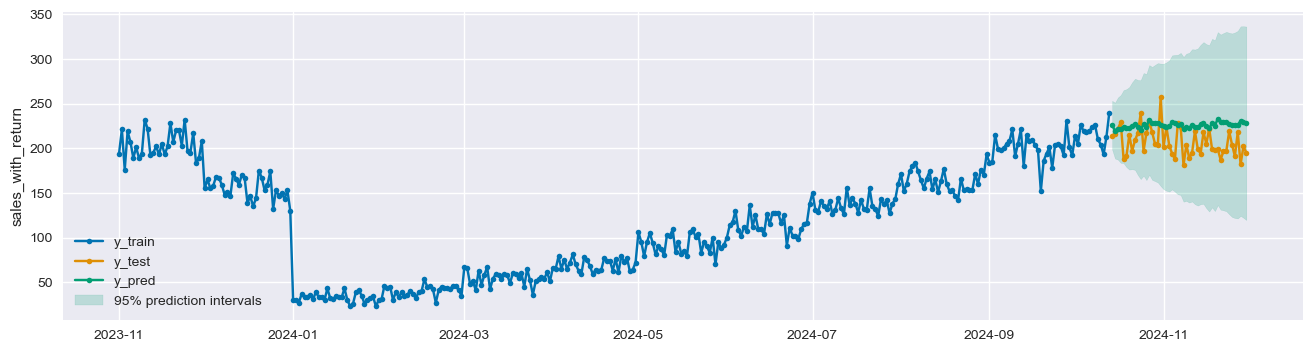

In [398]:
import statsmodels.api as sm

ets_aaa = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=24)
ets_aaa_res = ets_aaa.fit()
print(ets_aaa_res.summary())

h = 48 # test_size
df_forecast = ets_aaa_res.get_forecast(h).summary_frame()
y_train.index = pd.date_range(start=y_train.index[0], periods=len(y_train), freq='D')


fig, ax = plot_series(y_train, y_test, df_forecast['mean'], labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["mean_ci_lower"],
    df_forecast["mean_ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');